In [1]:
import fdapdepy as fdapde
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation

# mesh
nodes = np.loadtxt("unit_square/points.txt", dtype=float)
triangles = np.loadtxt("unit_square/elements.txt", dtype=int)
triangles = triangles - 1 # sempre stessa storia
boundary = np.loadtxt("unit_square/boundary.txt", dtype=int)
print(nodes.shape[1], triangles.shape[1]-1)
mesh = fdapde.domain(nodes, triangles, boundary)
print(mesh.embed_dim, mesh.local_dim, type(mesh))


2 2
2 2 <class 'fdapdepy.domain.domain2d'>


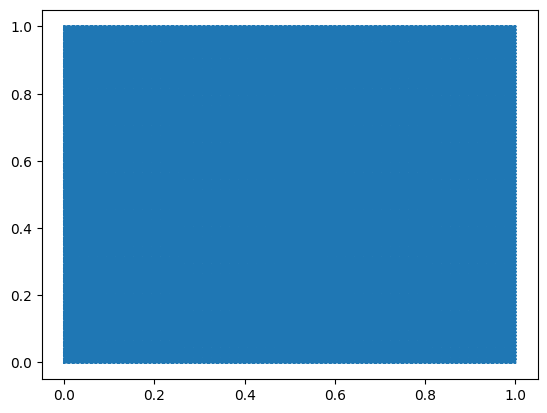

In [2]:
triangulation = Triangulation(mesh.nodes()[:,0], mesh.nodes()[:,1], mesh.elements())

fig, ax = plt.subplots()
ax.triplot(triangulation)

In [3]:
basis = fdapde.functional_basis(mesh,1)

In [4]:
# pde_type = 1 simple laplacian
# -lapl(u) = f
#  u = 0 
# u_ex = sin(pi x) sin(pi y)
u_ex = np.sin(np.pi * mesh.nodes()[:,0]) * np.sin(np.pi*mesh.nodes()[:,1])

In [6]:
# f
f = fdapde.function(basis)
lapl_f = -fdapde.laplacian(f)
type(lapl_f)

lapl_f.params.keys()
print( len(set(lapl_f.params.keys()) & set(('laplacian', ''))) == 1 )
print(len(set(lapl_f.params.keys()) & set(("laplacian", ""))))

print(set(lapl_f.params.keys()))
print(set(("laplacian", "")))

True
1
{'laplacian'}
{'', 'laplacian'}


In [7]:
pde = fdapde.pde(lapl_f)

KeyError: 'diff'

In [ ]:
# set dirichlet bc (è inutile in questo caso)
#_pde.set_dirichlet_bc(u_ex)

print( set(lapl_f.params.keys()) & set(("laplacian", "dt")) == 'laplacian' )
print("dt" in ("laplacian", "dt")) 

In [ ]:
# set forcing
quad_nodes = _pde.get_quadrature_nodes()
forcing = (1+np.pi*np.pi) * np.sin(np.pi * quad_nodes[:,0]) * np.sin(np.pi*quad_nodes[:,1])
_pde.set_forcing(forcing)

In [ ]:
# init
_pde.init()

In [ ]:
# compute solution
from scipy import sparse
print(_pde.stiff().shape)
print(_pde.force().shape)

In [ ]:
# set dirichlet bc
stiff = sparse.csr_matrix(_pde.stiff())
rhs = _pde.force()
for i in range(0, (len(boundary)-1)):
    stiff[i,:] = 0. * stiff[i,:]
    stiff[i,i] = 1.
    rhs[i] = u_ex[i]

In [ ]:
sol = sparse.linalg.spsolve(stiff, rhs)

print("err_l_inf = ", np.max(np.abs(sol - u_ex))) # :)